In [1]:
## Imports ##
#------------------------------------------------#
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.autograd as autograd
#------------------------------------------------#
import matplotlib.pyplot as plt
import numpy as np
from time import time
import math
import os
import sys
from tqdm import tqdm_notebook as tqdm
from numba import jit
#------------------------------------------------#
from data import Dataset
from train_isola import SiameseNetwork
#------------------------------------------------#
import scipy.spatial as sp 
import scipy.cluster.hierarchy as hc
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns

import networkx as nx
from sklearn.cluster import SpectralClustering, KMeans
#------------------------------------------------#

/home/gefenkohavi/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Device mode:  cuda


In [115]:
model = torch.load('model_isola_nodepth').cuda()

#Testing
batch_size = 256
accuracy = []
trainset = Dataset(train=False, split_size=.8, patches=False)
ts = trainset
trainloader = DataLoader(dataset=trainset, batch_size=batch_size)
# Dataset intrinsics
skip_len = 30#trainset.skip_len-1
ps = trainset.ps
shape = (460, 620)

model.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=3600, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=500, out_features=250, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace)
    (4): Linear(in_features=250, out_features=250, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace)
    (6): Linear(in_features=250, out_features=1, bi

In [116]:
def get_neighbors(x, y, i, j):
    xyc = [(x+skip_len, y, i+1, j), (x-skip_len, y, i-1, j), (x+skip_len, y+skip_len, i+1, j+1), 
           (x-skip_len, y+skip_len, i-1, j+1), (x+skip_len, y-skip_len, i+1, j-1), 
           (x-skip_len, y-skip_len, i-1, j+1), (x, y+skip_len, i, j+1), (x, y-skip_len, i, j-1),
           (x+skip_len*2, y, i+2, j),
           (x-skip_len*2, y-skip_len*2, i-2, j+2), 
           (x+skip_len*2, y+skip_len*2, i+2, j+2)]
    xyc = filter(lambda x: ps<x[0]<shape[0]-ps and 
                              ps<x[1]<shape[1]-ps, xyc)
    xyc = list(xyc)
    return xyc
def np_img2torch(img):
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2)
    img = img.cuda()
    return img
def torch_img2np(img):
    img = img.permute(0, 2, 3, 1)
    img = img.detach().cpu().numpy()
    img = img.squeeze(0)
    return img
def crop_edges(img_):
    # Shape = (x, y, dim)
    return img_[10:-10,10:-10,:]

In [120]:
print('starting')
# @jit
# def get_dists(img_):
#     dists = np.zeros((32*43, 32*43))
#     lst_len = 0
#     for Ai, Ax in enumerate(tqdm(range(ps, shape[0], skip_len))):
#         dists[Ai, Ai] = 1
#         for Aj, Ay in enumerate(range(ps, shape[1], skip_len)):
#             lst_len += 1
#             A = ts.get_from_xy(Ax, Ay, img_)
#             A_neighbors = get_neighbors(Ax, Ay, Ai, Aj)
#             for Bx, By, Bi, Bj in A_neighbors:
#                 # print(Ax, Ay, Ai, Aj, Bx, By, Bi, Bj)
#                 B = ts.get_from_xy(Bx, By, img_)
#                 if A.shape == B.shape: # != happens when reading corner
#                     C = model(A, B)[0][0].item()    
#                     dists[Ai*Aj+Aj, Bi*Bj+Bj] = C
#                     dists[Ai*Aj+Aj, Ai*Aj+Aj] = 1
#                     dists[Bi*Bj+Bj, Bi*Bj+Bj] = 1
#     return dists
def get_dists(img_):
    dists = np.zeros((32*43, 32*43))
    lst_len = 0
    for Ai, Ax in enumerate(tqdm(range(ps, shape[0], skip_len))):
        dists[Ai, Ai] = 1
        for Aj, Ay in enumerate(range(ps, shape[1], skip_len)):
            for Bi, Bx in enumerate(range())
            
            A = ts.get_from_xy(Ax, Ay, img_)
            A_neighbors = get_neighbors(Ax, Ay, Ai, Aj)
            for Bx, By, Bi, Bj in A_neighbors:
                # print(Ax, Ay, Ai, Aj, Bx, By, Bi, Bj)
                B = ts.get_from_xy(Bx, By, img_)
                if A.shape == B.shape: # != happens when reading corner
                    C = model(A[:,:3,:,:], B[:,:3,:,:])[0][0].item()    
                    dists[Ai*Aj+Aj, Bi*Bj+Bj] = C
                    dists[Ai*Aj+Aj, Ai*Aj+Aj] = 1
                    dists[Bi*Bj+Bj, Bi*Bj+Bj] = 1
    return dists
    
with torch.no_grad():
    # Construct tree
    img_ = trainset[59]
    img_ = crop_edges(img_)
    for i in [3]: # todo, didn't actually train with all chanels normalized
        img_[:,:,i] = (img_[:,:,i]-np.mean(img_[:,:,i])) / np.std(img_[:,:,i])
    start = time()
    img_ = np_img2torch(img_)
    dists = get_dists(img_)
    end = time()
    print(end-start)
    # dists=np.array(dists)  
#     print(lst_len)
#     print(Ai, Aj)
    print(dists.shape)

    # plt.figure()
    # plt.hist(dists)
    # plt.show()

    sc = SpectralClustering(5, affinity='precomputed', n_init=100)
    sc.fit(dists)
    print('spectral clustering')
    print(sc.labels_)

    # plt.figure()
    # plt.hist(sc.labels_)
    # plt.show()

    customPalette = [np.array([220,20,60]), 
                     np.array([255,69,0]), 
                     np.array([255,215,0]), 
                     np.array([240,230,140]), 
                     np.array([154,205,50]),
                     np.array([85,107,47]),
                     np.array([124,252,0]),
                     np.array([0,128,128]),
                     np.array([224,255,255]),
                     np.array([70,130,180]),
                     np.array([75,0,130]),
                     np.array([139,0,139]),
                     ]
    customPalette = [[cc/255 for cc in c] for c in customPalette]
    idx = 0
    img_ = torch_img2np(img_)
    img_2 = np.copy(img_)
    for Ai, Ax in enumerate(range(ps, shape[0], skip_len)):
        for Aj, Ay in enumerate(range(ps, shape[1], skip_len)):
            img_[Ax-ps:Ax+ps+1,Ay-ps:Ay+ps+1,:3] = customPalette[sc.labels_[idx]%12] 
            idx+=1

starting



3.090909481048584
(1376, 1376)


/home/gefenkohavi/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:709: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "
/home/gefenkohavi/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


spectral clustering
[2 0 0 ... 0 0 0]


In [121]:
print(sc.labels_.shape)
print(idx)

(1376,)
336


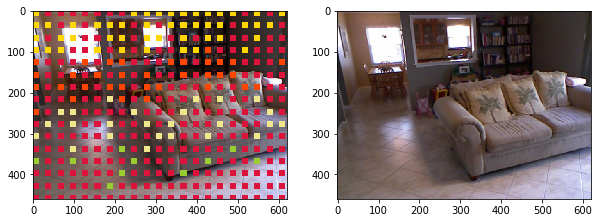

In [122]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(img_[:,:,:3])
plt.subplot(1, 2, 2)
plt.imshow(img_2[:,:,:3])
plt.show()


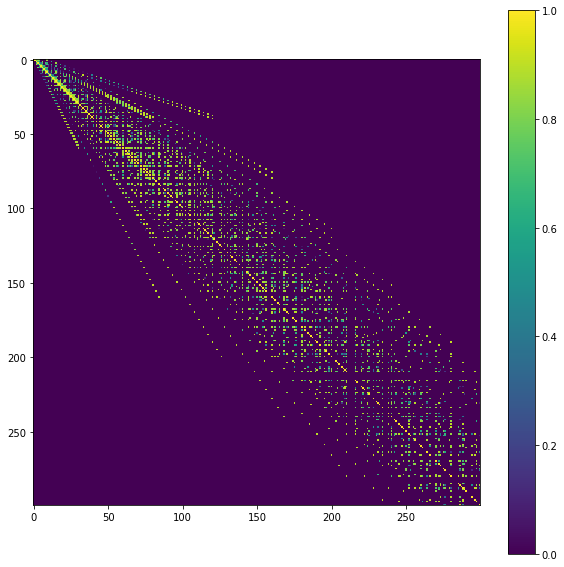

In [99]:
plt.figure(figsize=(10, 10))
plt.imshow(dists[:300, :300])
# plt.imshow(np.eye(20, 20))
plt.colorbar()
plt.show()

In [102]:
ds = np.copy(dists)
for i in range(ds.shape[0]):
    ds[i,i] = 1
    for j in range(ds.shape[1]):
        ds[j,i] = ds[i,j]
ds = 1-ds

In [103]:
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

method = 'complete'

linkage = hc.linkage(sp.distance.squareform(ds), method=method)

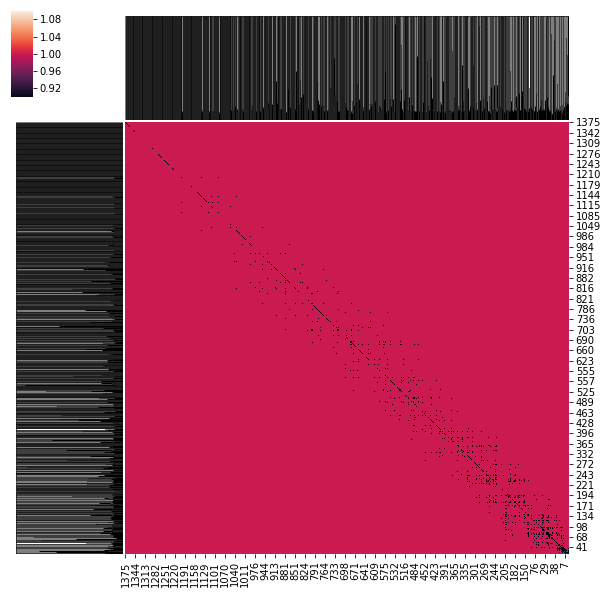

In [104]:
import seaborn as sns
sns.clustermap(ds, row_linkage=linkage, col_linkage=linkage, robust=True)

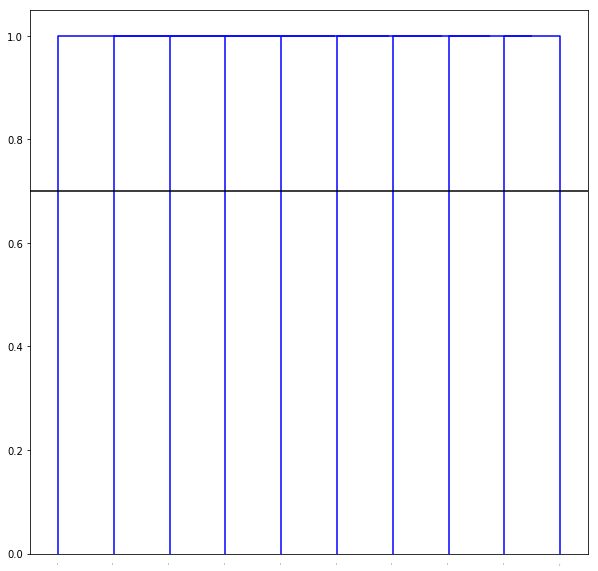

In [105]:
from scipy.cluster.hierarchy import dendrogram
thresh = .7
plt.figure(figsize=(10, 10))
dendrogram(
    linkage,
    truncate_mode='lastp',
    p=10, 
    leaf_rotation=90.,
    leaf_font_size=1.,
)
plt.axhline(y=thresh, c='k')
plt.show()

/home/gefenkohavi/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


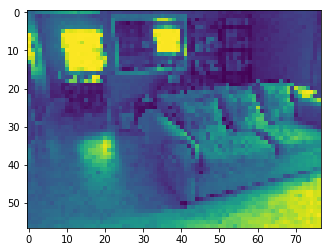

(57, 77)


In [113]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from skimage.transform import rescale, resize, downscale_local_mean
plt.figure()
plt.imshow(img_2[:,:,:3])
img_r = image_resized = resize(img_2[:,:,:3], (img_2.shape[0]//8, img_2.shape[1]//8))
plt.imshow(img_r[:,:,-1])
plt.show()
img_r = img_r[:,:,-1]
graph = image.img_to_graph(img_r)
print(img_r.shape)

Started Clustering


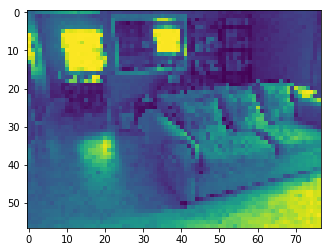

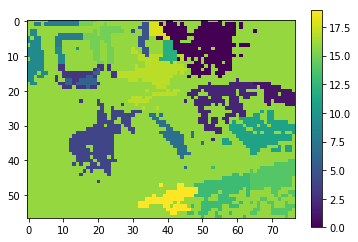

In [114]:
# graph.data = np.exp(-graph.data / graph.data.std())
print("Started Clustering")
labels = spectral_clustering(graph, n_clusters=20, eigen_solver='arpack')
labels = np.reshape(labels, (img_r.shape[0], img_r.shape[1]))

plt.figure()
plt.imshow(img_r)
plt.figure()
plt.imshow(labels)
plt.colorbar()
plt.show()